# Building a Better Board Game

### Import Libraries

In [38]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
# ggplot makes prettier plots. (plt.style isn't supported before matplotlib v1.4)
plt.style.use('ggplot')

## 1. Data Exploration

Read all of our data in as a pandas data frame

In [41]:
allData = pd.read_csv("../Data/CSV/games.csv")

How many observations (games) are in our set?

In [44]:
print("The data set contains {} games.").format(len(allData))

The data set contains 84593 games.


Get an idea of the range of values for each feature in the data

In [43]:
allData.describe()

,id,year,ratingScore,ratingCount,ratingStdDev,weightAvg,weightLightPct,weightMediumLightPct,weightMediumPct,weightMediumHeavyPct,weightHeavyPct,playerAgeMin,playtimeMin,playtimeMax,playersStatedMin,playersStatedMax,playersBestMin,playersBestMax,priceAverage,priceStdDev,
count,84593.000000,84593.000000,84593.000000,84593.000000,84593.000000,84593.000000,71714.000000,71714.000000,71714.000000,71714.000000,71714.000000,84593.000000,84593.000000,84593.000000,84593.00000,84593.000000,84593.000000,84593.000000,19461.000000,19461.000000,...
mean,80013.233152,1807.385008,4.279174,110.736988,0.774242,0.876848,19.957703,16.550744,10.183793,3.200719,1.401069,7.019162,47.198243,51.168395,1.98825,5.682491,2.219664,5.263934,24.716603,7.954304,...
std,63960.226532,588.475029,3.039157,929.482652,0.814887,1.160127,35.385330,29.738281,23.392949,12.743502,8.428136,6.808049,327.225953,341.891784,0.92677,55.144456,1.210552,54.600688,33.740133,16.690697,...
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.010000,0.000000,...
25%,23001.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,5.000000,2.00000,2.000000,2.000000,2.000000,9.950000,0.000000,...
50%,60049.000000,2004.000000,5.333330,2.000000,0.695211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,30.000000,30.000000,2.00000,4.000000,2.000000,4.000000,16.663333,3.925003,...
75%,139950.000000,2011.000000,6.716100,15.000000,1.419710,1.785700,25.000000,25.000000,0.000000,0.000000,0.000000,12.000000,60.000000,60.000000,2.00000,6.000000,2.000000,6.000000,29.084300,9.479418,...
max,202858.000000,2018.000000,10.000000,59423.000000,4.500000,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1333.000000,60120.000000,60120.000000,99.00000,11299.000000,99.000000,11299.000000,1300.000000,581.085046,...


It seems that most features have values for most games, with the exception of priceAverage and priceStdDev

In [46]:
feature = "priceAverage"
percentage = len(allData[feature].dropna())/float(len(allData)) * 100
print("{}% of games have a value for the '{}' feature.").format(percentage, feature)

23.0054496235% of games have a value for the 'priceAverage' feature.


How many games have values for *all* features in the set?

In [47]:
allWithoutNA = allData.dropna()
percentage = len(allWithoutNA)/float(len(allData)) * 100
print("{}% of games have a values for all features.").format(percentage, feature)
print("{} games remain once filtering out those with null feature values.").format(len(allWithoutNA))

22.5727897107% of games have a values for all features.
19095 games remain once filtering out those with null feature values.


Some games have feature values that we might choose to consider as outliers.

In [48]:
allWithoutNA.year.describe()

count    19095.000000
mean      1980.718408
std        209.432133
min      -3500.000000
25%       1994.000000
50%       2006.000000
75%       2012.000000
max       2016.000000
Name: year, dtype: float64

As you can see above, some games were published as early as 3500 B.C.
Perhaps we should limit the year of publication to exclude ancient Egyptian games.

In [49]:
since1950 = allWithoutNA.query("year >= 1950")
print("{} games remain once filtering out those published prior to 1950.").format(len(since1950))

18799 games remain once filtering out those published prior to 1950.


Ratings are crowd-sourced. Ratings may be less reliable if there were too few people contributing to the rating.

How many games have at least three votes cast toward their rating?

In [50]:
atLeastThreeRaters = since1950.query("ratingCount > 2")
print("{} games remain once filtering out those rated by fewer than 3 people").format(len(atLeastThreeRaters))

18141 games remain once filtering out those rated by fewer than 3 people


Our target variable is going to be 'ratingScore'.

Let's see how the ratingScore value is distributed.

In [51]:
df = atLeastThreeRaters
df.ratingScore.describe()

count    18141.000000
mean         6.496881
std          1.022268
min          1.000000
25%          5.857140
50%          6.546350
75%          7.217780
max         10.000000
Name: ratingScore, dtype: float64

It seems as if 1.0 is the minimum allowable score, and 10.0 is the max.

A histogram will probably help us see how these ratings are distributed.

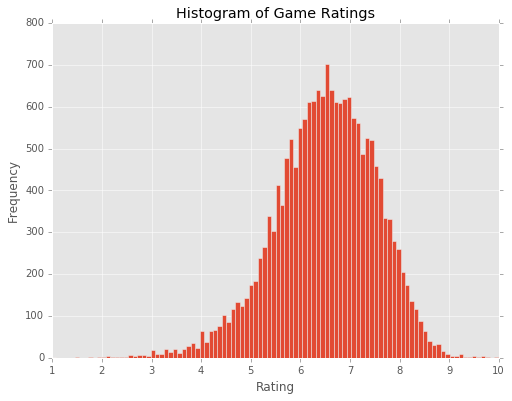

In [67]:
plt.figure(figsize=(8,6))
plt.hist(df.ratingScore, 100)
plt.xlim(xmin=1, xmax=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Game Ratings")
plt.show()

Well, that looks like a shifted Gaussian distribution. Ratings of 1.0 and 10.0 are quite uncommon.

# 2. Data Pre-processing

Let's separate the columns that we intend to use as features from that which is the target.

In [56]:
# Extract feature (X) and target (y) columns

# Why are we excluding features?
# 'id' holds no predictive value
# 'name', and 'url' are strings, and cannot be features in their current form
# 'ratingCount' and 'ratingStdDev' will likely be unavailable features during prediction
# 'ratingScore' is the target variable, and should not be used to train a model
excluded = ["id", "name", "url", "ratingScore", "ratingCount", "ratingStdDev"]
feature_cols = [col for col in df.columns if col not in excluded]

# This is our target
target_col = "ratingScore"

# Create an n*m data frame where n is the number of games, and m is the number of features
X_all = df[feature_cols]
# Create an n*1 data frame where n is the number of games, each with the single target feature
y_all = df[target_col]

We need to split this data into (at least) two portions.
* A training set
* A held-out test (or validation) set

An 80/20 split seems reasonable, with the amount of data we have available.

In [57]:
# Determine the number of observations to include in the training set
num_train = int(0.8 * df.shape[0])

# Select features (X) and corresponding labels (y) for the training and test sets
# train_test_split() shuffles data randomly. We will set the random state for consistency
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    train_size=num_train,
    random_state=12)

print "Training set includes {} samples".format(X_train.shape[0])
print "Test set includes     {} samples".format(X_test.shape[0])

Training set includes 14512 samples
Test set includes     3629 samples


With random sampling, we would anticipate the histogram of the target variable in the training and test sets to be similarly distributed.

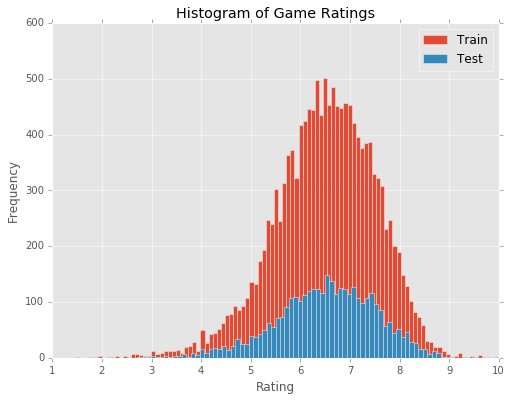

In [68]:
plt.figure(figsize=(8,6))
plt.hist(y_train, 100, label="Train")
plt.hist(y_test, 100, label="Test")
plt.legend(loc='upper right')
plt.xlim(xmin=1, xmax=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Game Ratings")
plt.show()

In [69]:
# Train a model
import time

def train_regressor(reg, X_train, y_train):
    print "Training {}...".format(reg.__class__.__name__)
    start = time.time()
    reg.fit(X_train, y_train)
    end = time.time()
    print "Done.\nTraining time (secs): {:.3f}".format(end - start)

# Random Forest is a tree-based learner.
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=2000, min_samples_split=5, random_state=12)

# Fit model to training data
train_regressor(reg, X_train, y_train)
# Show some information about the trained regressor.
print reg

Training RandomForestRegressor...
Done.
Training time (secs): 375.758
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=1, oob_score=False, random_state=12,
           verbose=0, warm_start=False)


In [70]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, mean_squared_error
def predict(reg, features, target):
    print "Predicting labels using {}...".format(reg.__class__.__name__)
    start = time.time()
    y_pred = reg.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return pd.Series(y_pred)

y_test_pred  = predict(reg, X_test, y_test)

Predicting labels using RandomForestRegressor...
Done!
Prediction time (secs): 5.614
Predicting labels using RandomForestRegressor...
Done!
Prediction time (secs): 1.314


In [ ]:
print "Mean Squared Error (train): {}".format(mean_squared_error(y_train, reg.oob_p))
print "Mean Squared Error (test) : {}".format(mean_squared_error(y_test,  y_test_pred))

In [ ]:
print "Confusion matrix (train):\n{}".format(confusion_matrix(np.rint(y_train), np.rint(y_train_pred), labels=range(0,11)))
print "Confusion matrix (test):\n{}".format(confusion_matrix(np.rint(y_test), np.rint(y_test_pred), labels=range(0,11)))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print "Exact agreement (train): {}".format(accuracy_score(np.rint(y_train), np.rint(y_train_pred)))
print "Exact agreement (test) : {}".format(accuracy_score(np.rint(y_test), np.rint(y_test_pred)))

In [ ]:
print "F1 Score (train): {}".format(f1_score(np.rint(y_train), np.rint(y_train_pred), average='weighted'))
print "F1 Score (test) : {}".format(f1_score(np.rint(y_test), np.rint(y_test_pred), average='weighted'))

In [ ]:
from scipy.stats import pearsonr
print "Pearson Correlation (train): {}".format(pearsonr(y_train, y_train_pred)[0])
print "Pearson Correlation (test) : {}".format(pearsonr(y_test, y_test_pred)[0])

In [37]:
plt.scatter(y_test, y_test_pred)
plt.plot([0, 10], [0, 10], 'k-')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

NameError: name 'y_test' is not defined